# Вводная часть

In [60]:
EPOCHES = 10

In [95]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.models import resnet18

import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
import random


%matplotlib inline

# Классы моделей

In [2]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.start = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.MaxPool2d(2), # 32 -> 16
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2), # 16 -> 8
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), 
            nn.MaxPool2d(2), # 8 -> 4
            nn.BatchNorm2d(32),
        )

        self.conv1 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
        )

        self.conv2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
        )

        self.head = nn.Sequential(
            nn.Linear(32*2*2, 100),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, images):
        x = self.start(images)
        x = x + self.conv1(x)
        x = x + self.conv2(x)

        x = nn.AvgPool2d(2)(x)
        x = x.flatten(1)
        logits = self.head(x)
        return logits

In [3]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))



def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)



class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [4]:
class StarRegression(nn.Module):
    def __init__(self, trained_list, BaseClass, warmup=None, *args, **kwargs):
        '''
        Constructs Star aggregation of models
        uses segments from empirical minimizers (trained models) via sigmoid

        args:
            trained_list - list of trained models (will be copied)
            BaseClass - class of new model,
                        which will be connected with trained_model
                        and trained alongside weights of models (self.l)
            *args, **kwargs - arguments for BaseClass initialization 
        '''

        super().__init__()

        self.trained_models = nn.ModuleList()
        for model in trained_list:
            self.trained_models.append(copy.deepcopy(model))
            for p in self.trained_models[-1].parameters():
                p.requires_grad = False
        if warmup is not None:
            self.training_model = copy.deepcopy(warmup)
            for p in self.training_model.parameters():
                p.requires_grad = True
        else:
            self.training_model = BaseClass(*args, **kwargs)

        self.weights = nn.Parameter(torch.zeros(len(trained_list)+1))
        self.weights.requires_grad = True


    def forward(self, x):
        outs = []
        for model in self.trained_models:
            outs.append(model(x))
        outs.append(self.training_model(x))
        return torch.stack(outs, -1) @ nn.functional.softmax(self.weights, dim=0)

In [5]:
class ParallelRegression(nn.Module):
    def __init__(self, BaseClass, model_num=2, *args, **kwargs):
        '''
        args:
            BaseClass - class of models,
                        which will be connected similarly to SegmentStarRegression
                        but trained in parallel
            model_num - number of base models
            *args, **kwargs - arguments for BaseClass initialization
        '''
        super().__init__()

        self.models = nn.ModuleList()
        for _ in range(model_num):
            self.models.append(BaseClass(*args, **kwargs))
        self.linear = nn.Linear(model_num, 1, bias=True)


    def forward(self, x):
        outs = []
        for model in self.models:
            outs.append(model(x))
        return self.linear(torch.stack(outs, -1)).squeeze()

# Подготовка к обучению

In [6]:
df = pd.read_csv('data/YearPredictionMSD.txt', header=None)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [7]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [8]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models

train_transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
            transforms.RandomHorizontalFlip(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True),
])

test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True),
])


orig_train_set = CIFAR10('CIFAR10', train=True, download=True)
orig_test_set  = CIFAR10('CIFAR10', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
class FastDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.transform = transform
        self.obj_num = len(dataset)

        self.objects = np.empty((self.obj_num, 32, 32, 3), dtype=np.uint8)
        self.classes = torch.empty((self.obj_num), dtype=torch.long)

        for i in range(self.obj_num):
            self.objects[i] = np.asarray(dataset[i][0].convert('RGB'))
            self.classes[i] = dataset[i][1]

    def __getitem__(self, idx):
        return self.transform(self.objects[idx]), self.classes[idx]
    
    def __len__(self):
        return self.obj_num
    
fast_train_set = FastDataset(orig_train_set, train_transform)
fast_test_set = FastDataset(orig_test_set, test_transform)

In [50]:
SEED = 0

# VALID_PROP = 0.1
# valid_len = round(VALID_PROP * len(fast_test_set))

# test_len = len(fast_test_set) - valid_len
# test_set, valid_set = random_split(fast_test_set,
#                                     [test_len, valid_len],
#                                     generator=torch.Generator().manual_seed(SEED)
# )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128

train_dataloader = DataLoader(fast_train_set, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True)
# valid_dataloader = DataLoader(valid_set, batch_size=batch_size, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(fast_test_set, batch_size=batch_size, num_workers=0, pin_memory=True)

criterion = nn.CrossEntropyLoss()

In [51]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device='cpu'):
    model.train()

    loss_sum = 0
    acc_sum = 0
    total = 0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)

        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_sum += loss.item() * y.shape[0]
        acc_sum += (y_pred.argmax(dim=-1) == y).sum().item()
        total += y.shape[0]

    return loss_sum / total, acc_sum / total


def evaluate_one_epoch(model_list, dataloader, criterion, device='cpu'):
    if not isinstance(model_list, list):
        model_list = [model_list]
    for model in model_list:
        model.eval()

    loss_sum = 0
    acc_sum = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model_list[0](x)
            for model in model_list[1:]:
                y_pred += model(x)
            y_pred /= len(model_list)

            loss = criterion(y_pred, y)
            loss_sum += loss.item() * y.shape[0]
            acc_sum += (y_pred.argmax(dim=-1) == y).sum().item()
            total += y.shape[0]
    return loss_sum / total, acc_sum / total


def train(model, train_dataloader, test_dataloader, epoch_num, optimizer, 
          device='cpu', eval_freq=2, plot_freq=2,name=None):
    '''
    args:
        model - model to be trained
        train_dataloader - dataloader of training dataset
        valid_dataloader - dataloader of validation dataset
        epoch_num - amount of epoches to train
        optimizer - optimizer
        scheduler - optimizer scheduler
        device - device to compute on
        tol - tolerance of loss, if difference is < tol, training is stopped
        eval_freq - every eval_freq epoches loss on validation dataset is calculated
        plot_graph - if true, then real time graph is shown, else loss is printed
        scale - scale by which you should multiply loss
        name - name of model
    
    returns:
        losses - list of avg loss on training dataset per every test_freq epoches
    '''

    start_time = time.time()

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epoch_num):
        loss, acc = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        train_losses += [loss]
        train_accs += [acc]
            
        if epoch % eval_freq == eval_freq-1:
            loss, acc = evaluate_one_epoch([model], test_dataloader, criterion, device)
            test_losses += [loss]
            test_accs += [acc]

        if epoch % plot_freq == plot_freq-1:
            fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
            axs[0].plot(range(len(train_losses)), train_losses, label='train')
            axs[0].plot(range(eval_freq-1, len(test_losses)*eval_freq, eval_freq), test_losses, label='test')
            axs[0].set(ylabel = 'Cross Entropy Loss', xlabel='Epoch', title='Training Loss')
            axs[0].legend()

            axs[1].plot(range(len(train_accs)), train_accs, label='train')
            axs[1].plot(range(eval_freq-1, len(test_accs)*eval_freq, eval_freq), test_accs, label='test')
            axs[1].set(ylabel = 'Accuracy', xlabel='Epoch', title='Training Accuracy')
            axs[1].legend()
            
            clear_output()
            plt.show()
            print(name, 'epoch number ', epoch, '\n')
            print('time training:', round(time.time() - start_time, 1), 'sec')
            print('train acc:', train_accs[-1])
            print('test acc:',  test_accs[-1], '\n\n')

    training_time = round(time.time() - start_time, 1)
    print("Training time:", training_time, "seconds")

    return train_losses, train_accs, training_time

# Обучение моделей

In [58]:
def add_res(results, name, add_row):
    '''
    Adds new row with index "name" to DataFrame
    Args:
        results -  pd.DataFrame containing results for all models
        name - name of new row
        add_row - row which will be added
    '''
    if name not in results.index:
        results.loc[name] = add_row
        return

    res_row = []
    for i, col in enumerate(results):
        res_row += [results.loc[name,col] + add_row[i]]
    results.loc[name] = res_row


def make_experiment(results, model_class=ResNet9, epoches=10, base_am=3, warmup_epoches=3):
    '''
    Args:
        results - pd.DataFrame containing results for all models
        model_class - Class for each base block
        epoches - total number of epoches for each step of algorithm
        base_am - maximum d (there will be total of base_am + 1 blocks)
    returns:
        results - changed pd.DataFrame containing old and new results
    '''

#     bases = []
    
#     ensemble_times = []
#     scheduler = None
    
#     for i in range(base_am+1):
#         bases.append(model_class())
#         bases[i].to(device)

#         optimizer = torch.optim.Adam(bases[i].parameters(), lr=1e-3, weight_decay=1e-3)
#         losses, accs, time = train(bases[i], train_dataloader, test_dataloader, epoches,
#                              optimizer, device=device, name="base model " + str(i+1))
    
#         if len(ensemble_times):
#             ensemble_times += [ensemble_times[-1] + time]
#         else:
#             ensemble_times += [time]

#         loss, acc = evaluate_one_epoch(bases[i], test_dataloader, criterion, device)
#         train_loss, train_acc = evaluate_one_epoch(bases[i], train_dataloader, criterion, device)
        
#         add_res(results, 'Big NN 0', [[loss], [acc], [train_loss], [train_acc], [time]])
    
#     # ensemble -----------------------------------------------------------------

#     for i in range(base_am):
#         loss, acc = evaluate_one_epoch(bases[:i+2], test_dataloader, criterion, device)
#         train_loss, train_acc = evaluate_one_epoch(bases[:i+2], train_dataloader, criterion, device)
            
#         add_res(results, 'Ensemble ' + str(i+1), [[loss], [acc], [train_loss], [train_acc], [ensemble_times[i+1]]])

#     # star ---------------------------------------------------------------------

#     star_models = []

#     for i in range(base_am):
#         name = 'Classic Star (no warm-up) ' + str(i+1)
#         star = StarRegression(bases[:i+1], model_class).to(device)
#         optimizer = torch.optim.Adam(star.parameters(), lr=1e-3, weight_decay=1e-3)
        
#         losses, accs, time = train(star, train_dataloader, test_dataloader, epoches, optimizer, device=device, name=name)

#         loss, acc = evaluate_one_epoch(star, test_dataloader, criterion, device)
#         train_loss, train_acc = evaluate_one_epoch(star, train_dataloader, criterion, device)
            
#         add_res(results, name, [[loss], [acc], [train_loss], [train_acc], [time + ensemble_times[i]]])
  

#     # warmup star ---------------------------------------------------------------------

#     warmed = model_class().to(device)

#     optimizer = torch.optim.Adam(warmed.parameters(), lr=1e-3, weight_decay=1e-3)
#     _, _, warmup_time = train(warmed, train_dataloader, test_dataloader, warmup_epoches,
#                            optimizer, device=device, name='warmup')

#     for i in range(base_am):
#         name = 'Classic Star (new warm-up) ' + str(i+1)
#         star = StarRegression(bases[:i+1], model_class, warmup=warmed).to(device)
#         optimizer = torch.optim.Adam(star.parameters(), lr=1e-3, weight_decay=1e-3)
        
#         losses, accs, time = train(star, train_dataloader, test_dataloader, epoches - warmup_epoches, optimizer, device=device, name=name)

#         loss, acc = evaluate_one_epoch(star, test_dataloader, criterion, device)
#         train_loss, train_acc = evaluate_one_epoch(star, train_dataloader, criterion, device)
            
#         add_res(results, name, [[loss], [acc], [train_loss], [train_acc], [time + warmup_time + ensemble_times[i]]])


#     parallel -----------------------------------------------------------------

    parallel_models = []

    for i in range(base_am):
        name = 'Big NN ' + str(i+1)
        parallel_model = ParallelRegression(model_class, i+2).to(device)

        optimizer = torch.optim.Adam(parallel_model.parameters(), lr=1e-3, weight_decay=1e-3)
        
        losses, accs, time = train(parallel_model, train_dataloader, test_dataloader, epoches, optimizer, device=device, name=name)

        loss, acc = evaluate_one_epoch(parallel_model, test_dataloader, criterion, device)
        train_loss, train_acc = evaluate_one_epoch(parallel_model, train_dataloader, criterion, device)
        
        add_res(results, name, [[loss], [acc], [train_loss], [train_acc], [time]])

    return results

In [22]:
results = pd.DataFrame({'Loss' : [], 'Accuracy' : [], 'Train Loss' : [], 'Train Accuracy' : [], 'Time' : []})
NUM_EXPERIMENTS = 3
set_random_seed(0)
for i in range(NUM_EXPERIMENTS):
    results = make_experiment(results, model_class=ResNet9, epoches=10, warmup_epoches=2) #, base_am=3

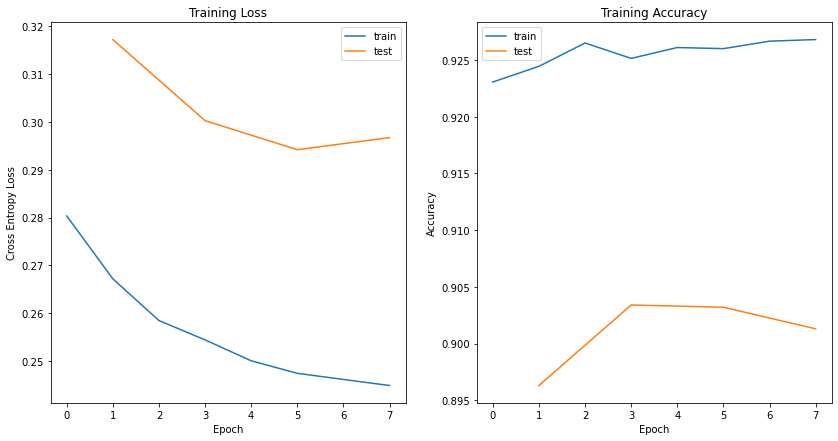

Classic Star (new warm-up) 3 epoch number  7 

time training: 1046.1 sec
train acc: 0.9268
test acc: 0.9013 


Training time: 1046.1 seconds


In [20]:
results = make_experiment(results, model_class=ResNet9, base_am=3, epoches=10, warmup_epoches=2)

In [23]:
results.to_csv('results/first сifar results.csv')
saved = results.copy()
results

,Loss,Accuracy,Train Loss,Train Accuracy,Time
Big NN 0,"[0.4001814534187317, 0.4599046495437622, 0.511...","[0.8677, 0.8436, 0.8244, 0.8457, 0.839, 0.8444...","[0.35745231853961945, 0.40198987390518187, 0.4...","[0.88476, 0.86182, 0.83478, 0.86832, 0.85316, ...","[900.5, 782.8, 757.3, 758.1, 757.5, 758.5, 776..."
Ensemble 1,"[0.3430506531238556, 0.36581522212028506, 0.37...","[0.8861, 0.8734, 0.8727]","[0.297635410490036, 0.3075022952079773, 0.3049...","[0.90502, 0.898, 0.89716]","[1683.3, 1740.5, 1557.6]"
Ensemble 2,"[0.3155895233631134, 0.3319969253540039, 0.328...","[0.8969, 0.8877, 0.8877]","[0.27331409185409544, 0.2809423043346405, 0.26...","[0.91764, 0.9113, 0.91328]","[2440.6, 2581.6, 2327.8]"
Ensemble 3,"[0.29925513768196105, 0.32006648807525634, 0.3...","[0.9023, 0.893, 0.8891]","[0.24825520288467406, 0.2674123253154755, 0.25...","[0.92596, 0.91692, 0.91746]","[3198.7, 3398.3, 3085.9]"
Ensemble 4,"[0.29681019439697265, 0.31858636384010314]","[0.9025, 0.8912]","[0.24506483757019043, 0.2651513268852234]","[0.9272, 0.91612]","[3956.2, 4177.6]"
Ensemble 5,"[0.28771511678695677, 0.2946513738632202]","[0.9046, 0.9023]","[0.23841904188156127, 0.24606001117229462]","[0.93086, 0.92656]","[4714.7, 4934.400000000001]"
Classic Star (no warm-up) 1,"[0.3582811215400696, 0.35210523896217344, 0.35...","[0.8821, 0.8789, 0.8819]","[0.3135467227077484, 0.3146791537570953, 0.296...","[0.90172, 0.9019, 0.90802]","[1830.3, 1707.2, 1724.8]"
Classic Star (no warm-up) 2,"[0.3108438994407654, 0.3160343985557556, 0.313...","[0.898, 0.8933, 0.8964]","[0.2569754233264923, 0.26269870041847226, 0.25...","[0.92332, 0.92038, 0.9201]","[2788.0, 2844.2, 2663.1]"
Classic Star (no warm-up) 3,"[0.292877231502533, 0.29854049582481385, 0.294...","[0.9029, 0.9034, 0.9023]","[0.23867048714160918, 0.24337536680221558, 0.2...","[0.92846, 0.92708, 0.92818]","[3718.5, 3858.3999999999996, 3652.1000000000004]"
Classic Star (no warm-up) 4,"[0.2845957246303558, 0.2913079014778137]","[0.9071, 0.9047]","[0.22883741600513458, 0.23787778925895692]","[0.93162, 0.9294]","[4650.299999999999, 4848.8]"


In [38]:
def snap_train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler=None, device='cpu'):
    model.train()

    loss_sum = 0
    acc_sum = 0
    total = 0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)

        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_sum += loss.item() * y.shape[0]
        acc_sum += (y_pred.argmax(dim=-1) == y).sum().item()
        total += y.shape[0]
        if scheduler is not None:
            scheduler.step()

    return loss_sum / total, acc_sum / total



def snapshot_train(model, train_dataloader, test_dataloader, epoch_num,
                   device='cpu', snap_freq=10, eval_freq=2, plot_freq=2, name=None):
    '''
    args:
        model - model to be trained
        train_dataloader - dataloader of training dataset
        valid_dataloader - dataloader of validation dataset
        epoch_num - amount of epoches to train
        optimizer - optimizer
        device - device to compute on
        tol - tolerance of loss, if difference is < tol, training is stopped
        eval_freq - every eval_freq epoches loss on validation dataset is calculated
        plot_graph - if true, then real time graph is shown, else loss is printed
        scale - scale by which you should multiply loss
        name - name of model
    
    returns:
        losses - list of avg loss on training dataset per every test_freq epoches
    '''

    start_time = time.time()

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    snapshots = []
    snap_times = []
    
    
    snapshots = []
    snap_times = []
    
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dataloader) * snap_freq)

    for epoch in range(epoch_num):
        loss, acc = snap_train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler, device)
        train_losses += [loss]
        train_accs += [acc]
            
        if eval_freq is not None and epoch % eval_freq == eval_freq-1:
            loss, acc = evaluate_one_epoch([model], test_dataloader, criterion, device)
            test_losses += [loss]
            test_accs += [acc]
            
        if epoch % snap_freq == snap_freq - 1:
            snapshots += [copy.deepcopy(model)]
            snap_times += [round(time.time() - start_time)]

            optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dataloader) * snap_freq)


        if epoch % plot_freq == plot_freq-1:
            fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
            axs[0].plot(range(len(train_losses)), train_losses, label='train')
            if eval_freq is not None:
                axs[0].plot(range(eval_freq-1, len(test_losses)*eval_freq, eval_freq), test_losses, label='test')
            axs[0].set(ylabel = 'Cross Entropy Loss', xlabel='Epoch', title='Training Loss')
            axs[0].legend()
        
            axs[1].plot(range(len(train_accs)), train_accs, label='train')
            if eval_freq is not None:
                axs[1].plot(range(eval_freq-1, len(test_accs)*eval_freq, eval_freq), test_accs, label='test')
            axs[1].set(ylabel = 'Accuracy', xlabel='Epoch', title='Training Accuracy')
            axs[1].legend()
            
            clear_output()
            plt.show()
            print(name, 'epoch number ', epoch, '\n')
            print('time training:', round(time.time() - start_time, 1), 'sec')
            print('train acc:', train_accs[-1])
            print('test acc:',  test_accs[-1], '\n\n')

    return snapshots, train_losses, np.array(snap_times)

In [46]:
def make_snapshot_experiment(results, model_class=ResNet9, epoches=10, base_am=3, warmup_epoches=2):
    base = model_class().to(device)
    snapshots, losses, cum_times = snapshot_train(base, train_dataloader, test_dataloader, epoches*(base_am+1),
                                                  device=device, snap_freq=epoches, name='snapshot')
    
    snap_times = cum_times.copy()
    snap_times[1:] = np.diff(cum_times)
        
    for i in range(len(snapshots)):
        snapshots[i].to(device)
        loss, acc = evaluate_one_epoch(snapshots[i], test_dataloader, criterion, device)
        train_loss, train_acc = evaluate_one_epoch(snapshots[i], train_dataloader, criterion, device)
        add_res(results, 'Snapshot', [[loss], [acc], [train_loss], [train_acc], [snap_times[i]]])    
    

    # ensemble -----------------------------------------------------------------
    
    for i in range(base_am):
        loss, acc = evaluate_one_epoch(snapshots[:i+2], test_dataloader, criterion, device)
        train_loss, train_acc = evaluate_one_epoch(snapshots[:i+2], train_dataloader, criterion, device)
        
        add_res(results, 'Snap Ensemble ' + str(i+1), [[loss], [acc], [train_loss], [train_acc], [cum_times[i+1]]])

    # star ---------------------------------------------------------------------

    star_models = []

    for i in range(base_am):
        name = 'Snap Star (no warm-up) ' + str(i+1)
        star = StarRegression(snapshots[:i+1], model_class).to(device)
        optimizer = torch.optim.Adam(star.parameters(), lr=1e-3, weight_decay=1e-3)
        
        losses, accs, time = train(star, train_dataloader, test_dataloader, epoches, optimizer, device=device, name=name)

        loss, acc = evaluate_one_epoch(star, test_dataloader, criterion, device)
        train_loss, train_acc = evaluate_one_epoch(star, train_dataloader, criterion, device)
            
        add_res(results, name, [[loss], [acc], [train_loss], [train_acc], [time + cum_times[i]]])


    # warmup star ---------------------------------------------------------------------


    warmed = model_class().to(device)

    optimizer = torch.optim.Adam(warmed.parameters(), lr=1e-3, weight_decay=1e-3)
    _, _, warmup_time = train(warmed, train_dataloader, test_dataloader, warmup_epoches,
                             optimizer, device=device, name='warmup')


    for i in range(base_am):
        name = 'Snap Star (new warm-up) ' + str(i+1)
        star = StarRegression(snapshots[:i+1], model_class, warmup=warmed).to(device)
        optimizer = torch.optim.Adam(star.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler=None
        
        losses, accs, time = train(star, train_dataloader, test_dataloader, epoches - warmup_epoches, optimizer, device=device, name=name)

        loss, acc = evaluate_one_epoch(star, test_dataloader, criterion, device)
        train_loss, train_acc = evaluate_one_epoch(star, train_dataloader, criterion, device)
            
        add_res(results, name, [[loss], [acc], [train_loss], [train_acc], [time + warmup_time + cum_times[i]]])


    # snap warmup star ---------------------------------------------------------------------



    for i in range(base_am):
        warmed = copy.deepcopy(snapshots[i])

        optimizer = torch.optim.Adam(warmed.parameters(), lr=1e-3, weight_decay=1e-3)
        _, _, warmup_time = snapshot_train(warmed, train_dataloader, test_dataloader, warmup_epoches,
                                           device=device, snap_freq=warmup_epoches, name='warmup')

        name = 'Snap Star (shot warm-up) ' + str(i+1)
        star = StarRegression(snapshots[:i+1], model_class, warmup=warmed).to(device)
        optimizer = torch.optim.Adam(star.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler=None
        
        losses, accs, time = train(star, train_dataloader, test_dataloader, epoches - warmup_epoches, optimizer, device=device, name=name)

        loss, acc = evaluate_one_epoch(star, test_dataloader, criterion, device)
        train_loss, train_acc = evaluate_one_epoch(star, train_dataloader, criterion, device)
            
        add_res(results, name, [[loss], [acc], [train_loss], [train_acc], [time + warmup_time + cum_times[i]]])

    return results

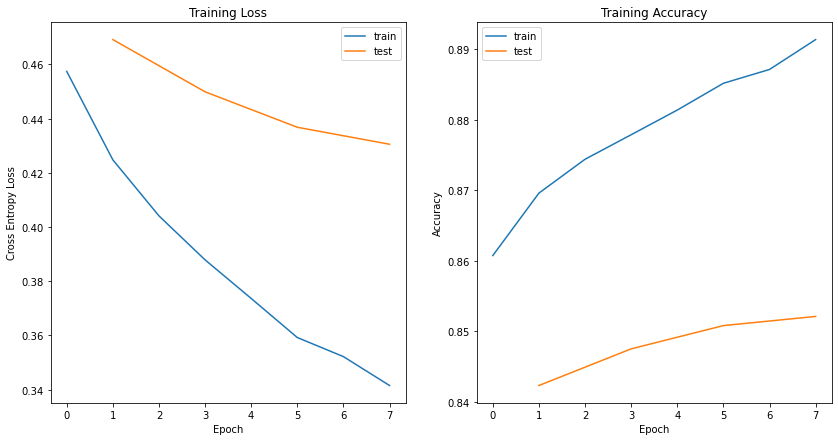

Snap Star (shot warm-up) 3 epoch number  7 

time training: 1021.7 sec
train acc: 0.89138
test acc: 0.8521 


Training time: 1021.7 seconds


In [48]:
set_random_seed(0)
NUM_EXPERIMENTS=3
for i in range(NUM_EXPERIMENTS):
    results = make_snapshot_experiment(results, epoches=10, warmup_epoches=2, base_am=3)

In [52]:
results.to_csv('results/cifar results.csv')

In [64]:
copy_res

,Loss,Accuracy,Train Loss,Train Accuracy,Time,d
Big NN 0,"[0.4001814534187317, 0.4599046495437622, 0.511...","[0.8677, 0.8436, 0.8244, 0.8457, 0.839, 0.8444...","[0.35745231853961945, 0.40198987390518187, 0.4...","[0.88476, 0.86182, 0.83478, 0.86832, 0.85316, ...","[900.5, 782.8, 757.3, 758.1, 757.5, 758.5, 776...",0
Ensemble 1,"[0.3430506531238556, 0.36581522212028506, 0.37...","[0.8861, 0.8734, 0.8727]","[0.297635410490036, 0.3075022952079773, 0.3049...","[0.90502, 0.898, 0.89716]","[1683.3, 1740.5, 1557.6]",1
Ensemble 2,"[0.3155895233631134, 0.3319969253540039, 0.328...","[0.8969, 0.8877, 0.8877]","[0.27331409185409544, 0.2809423043346405, 0.26...","[0.91764, 0.9113, 0.91328]","[2440.6, 2581.6, 2327.8]",2
Ensemble 3,"[0.29925513768196105, 0.32006648807525634, 0.3...","[0.9023, 0.893, 0.8891]","[0.24825520288467406, 0.2674123253154755, 0.25...","[0.92596, 0.91692, 0.91746]","[3198.7, 3398.3, 3085.9]",3
Ensemble 4,"[0.29681019439697265, 0.31858636384010314]","[0.9025, 0.8912]","[0.24506483757019043, 0.2651513268852234]","[0.9272, 0.91612]","[3956.2, 4177.6]",4
Ensemble 5,"[0.28771511678695677, 0.2946513738632202]","[0.9046, 0.9023]","[0.23841904188156127, 0.24606001117229462]","[0.93086, 0.92656]","[4714.7, 4934.400000000001]",5
Classic Star (no warm-up) 1,"[0.3582811215400696, 0.35210523896217344, 0.35...","[0.8821, 0.8789, 0.8819]","[0.3135467227077484, 0.3146791537570953, 0.296...","[0.90172, 0.9019, 0.90802]","[1830.3, 1707.2, 1724.8]",1
Classic Star (no warm-up) 2,"[0.3108438994407654, 0.3160343985557556, 0.313...","[0.898, 0.8933, 0.8964]","[0.2569754233264923, 0.26269870041847226, 0.25...","[0.92332, 0.92038, 0.9201]","[2788.0, 2844.2, 2663.1]",2
Classic Star (no warm-up) 3,"[0.292877231502533, 0.29854049582481385, 0.294...","[0.9029, 0.9034, 0.9023]","[0.23867048714160918, 0.24337536680221558, 0.2...","[0.92846, 0.92708, 0.92818]","[3718.5, 3858.3999999999996, 3652.1000000000004]",3
Classic Star (no warm-up) 4,"[0.2845957246303558, 0.2913079014778137]","[0.9071, 0.9047]","[0.22883741600513458, 0.23787778925895692]","[0.93162, 0.9294]","[4650.299999999999, 4848.8]",4


In [82]:
results = copy_res.copy()

In [85]:
results = results.drop([
    'Ensemble 4', 'Ensemble 5',
    'Classic Star (no warm-up) 4', 'Classic Star (no warm-up) 5',
    'Classic Star (new warm-up) 4', 'Classic Star (new warm-up) 5'
                       
])

In [86]:
results = results.rename(index={
    'Snap Star (no warm-up)1': 'Snap Star (no warm-up) 1',
    'Snap Star (no warm-up)2': 'Snap Star (no warm-up) 2',
    'Snap Star (no warm-up)3': 'Snap Star (no warm-up) 3',
    'Snapshot' : 'Snapshot 0'
})

results

,Loss,Accuracy,Train Loss,Train Accuracy,Time,d
Big NN 0,"[0.4001814534187317, 0.4599046495437622, 0.511...","[0.8677, 0.8436, 0.8244, 0.8457, 0.839, 0.8444...","[0.35745231853961945, 0.40198987390518187, 0.4...","[0.88476, 0.86182, 0.83478, 0.86832, 0.85316, ...","[900.5, 782.8, 757.3, 758.1, 757.5, 758.5, 776...",0
Ensemble 1,"[0.3430506531238556, 0.36581522212028506, 0.37...","[0.8861, 0.8734, 0.8727]","[0.297635410490036, 0.3075022952079773, 0.3049...","[0.90502, 0.898, 0.89716]","[1683.3, 1740.5, 1557.6]",1
Ensemble 2,"[0.3155895233631134, 0.3319969253540039, 0.328...","[0.8969, 0.8877, 0.8877]","[0.27331409185409544, 0.2809423043346405, 0.26...","[0.91764, 0.9113, 0.91328]","[2440.6, 2581.6, 2327.8]",2
Ensemble 3,"[0.29925513768196105, 0.32006648807525634, 0.3...","[0.9023, 0.893, 0.8891]","[0.24825520288467406, 0.2674123253154755, 0.25...","[0.92596, 0.91692, 0.91746]","[3198.7, 3398.3, 3085.9]",3
Classic Star (no warm-up) 1,"[0.3582811215400696, 0.35210523896217344, 0.35...","[0.8821, 0.8789, 0.8819]","[0.3135467227077484, 0.3146791537570953, 0.296...","[0.90172, 0.9019, 0.90802]","[1830.3, 1707.2, 1724.8]",1
Classic Star (no warm-up) 2,"[0.3108438994407654, 0.3160343985557556, 0.313...","[0.898, 0.8933, 0.8964]","[0.2569754233264923, 0.26269870041847226, 0.25...","[0.92332, 0.92038, 0.9201]","[2788.0, 2844.2, 2663.1]",2
Classic Star (no warm-up) 3,"[0.292877231502533, 0.29854049582481385, 0.294...","[0.9029, 0.9034, 0.9023]","[0.23867048714160918, 0.24337536680221558, 0.2...","[0.92846, 0.92708, 0.92818]","[3718.5, 3858.3999999999996, 3652.1000000000004]",3
Classic Star (new warm-up) 1,"[0.35132595133781436, 0.34671875286102294, 0.3...","[0.8842, 0.8817, 0.8829]","[0.3053761303329468, 0.308457942943573, 0.2924...","[0.90642, 0.9049, 0.90828]","[1796.2, 1705.0, 1725.6999999999998]",1
Classic Star (new warm-up) 2,"[0.31103485140800474, 0.3120883293628693, 0.31...","[0.898, 0.8964, 0.8957]","[0.259398263630867, 0.2600865338802338, 0.2583...","[0.9229, 0.92116, 0.92064]","[2717.8, 2797.6000000000004, 2669.2]",2
Classic Star (new warm-up) 3,"[0.29291184635162354, 0.2992772318840027, 0.29...","[0.9029, 0.9035, 0.9013]","[0.2408954661655426, 0.24411217144966124, 0.24...","[0.92776, 0.92746, 0.92738]","[3613.5, 3839.7, 3534.5]",3


In [ ]:
for idx in results.index:
    d = idx.rsplit(' ', 1)[1]
    results.loc[idx, 'd'] = d 
results.sort_values(by='d', inplace=True, ascending=False)

In [102]:
converted_list = []

for idx in results.index:
    name = idx.rsplit(' ', 1)[0]
#     mean_mse = np.mean(results.loc[idx, 'Loss'])
#     mean_mse = np.std(results.loc[idx, 'Loss'])
    mean_acc = np.mean(results.loc[idx, 'Accuracy'])
    std_acc = np.std(results.loc[idx, 'Accuracy'])
    mean_tr_acc = np.mean(results.loc[idx, 'Train Accuracy'])
    std_tr_acc = np.std(results.loc[idx, 'Train Accuracy'])
    cur_time = np.mean(results.loc[idx, 'Time'])
    d = int(results.loc[idx, 'd'])

    
    converted_list.append([name, d, str(np.round(mean_acc, 3)) + ' ± ' + str(np.round(std_acc, 3)),
                          str(np.round(mean_tr_acc, 3)) + ' ± ' + str(np.round(std_tr_acc, 3)), round(cur_time)])
    print('{} & {} & ${} \pm {}$ & {} & {} \\\\'.format(
          name, d, np.round(mean_acc, 3), np.round(std_acc, 3), 
          np.round(mean_tr_acc, 3), round(cur_time))
    )

converted_results = pd.DataFrame(converted_list, 
        columns=['model', 'd', 'Accuracy', 'Train Accuracy', 'TIME (sec)'])

converted_results.to_csv(f'Cifar results.csv', index=False)

Snap Ensemble & 3 & $0.852 \pm 0.002$ & 0.891 & 3021 \\
Classic Star (no warm-up) & 3 & $0.903 \pm 0.0$ & 0.928 & 3743 \\
Snap Star (shot warm-up) & 3 & $0.852 \pm 0.002$ & 0.892 & 3443 \\
Snap Star (new warm-up) & 3 & $0.871 \pm 0.004$ & 0.904 & 3445 \\
Snap Star (no warm-up) & 3 & $0.853 \pm 0.003$ & 0.895 & 3549 \\
Classic Star (new warm-up) & 3 & $0.903 \pm 0.001$ & 0.928 & 3663 \\
Big NN & 3 & $0.864 \pm 0.0$ & 0.883 & 3020 \\
Ensemble & 3 & $0.895 \pm 0.006$ & 0.92 & 3228 \\
Classic Star (no warm-up) & 2 & $0.896 \pm 0.002$ & 0.921 & 2765 \\
Big NN & 2 & $0.828 \pm 0.0$ & 0.844 & 2308 \\
Snap Ensemble & 2 & $0.836 \pm 0.0$ & 0.867 & 2271 \\
Ensemble & 2 & $0.891 \pm 0.004$ & 0.914 & 2450 \\
Snap Star (shot warm-up) & 2 & $0.837 \pm 0.006$ & 0.86 & 2553 \\
Snap Star (no warm-up) & 2 & $0.83 \pm 0.002$ & 0.855 & 2624 \\
Classic Star (new warm-up) & 2 & $0.897 \pm 0.001$ & 0.922 & 2728 \\
Snap Star (new warm-up) & 2 & $0.847 \pm 0.006$ & 0.868 & 2554 \\
Classic Star (new warm-up) & 

In [98]:
converted_results

,model,d,Accuracy,Train Accuracy,TIME (sec)
0,Snap Ensemble,3,0.852 ± 0.002,0.891 ± 0.0,3021
1,Classic Star (no warm-up),3,0.903 ± 0.0,0.928 ± 0.001,3743
2,Snap Star (shot warm-up),3,0.852 ± 0.002,0.892 ± 0.001,3443
3,Snap Star (new warm-up),3,0.871 ± 0.004,0.904 ± 0.007,3445
4,Snap Star (no warm-up),3,0.853 ± 0.003,0.895 ± 0.001,3549
5,Classic Star (new warm-up),3,0.903 ± 0.001,0.928 ± 0.0,3663
6,Big NN,3,0.864 ± 0.0,0.883 ± 0.0,3020
7,Ensemble,3,0.895 ± 0.006,0.92 ± 0.004,3228
8,Classic Star (no warm-up),2,0.896 ± 0.002,0.921 ± 0.001,2765
9,Big NN,2,0.828 ± 0.0,0.844 ± 0.0,2308
